# Churn Prediction

## Problem Statement

There is a telecom company that offers phone and internet services. There is a problem: some of our customers are churning. We would like to build a model that can identify the customers that are likely to churn. We have collected a dataset about our customers: what type of services they use, how much they paid, and how long they stayed with us. We also know who canceled their contracts and stopped using our services (churned). 

## What's in this section

In this notebook, we are going to work in phase III of our model training. We are going to use `Recursive Feature Elimination` and `Univariate selection` and train the models. We will then compare the model performance using the evaluation metrics trained in the current phase and in the previous phases.

## Imports

In [3]:
# usual imports 
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# plt.style.use('seaborn')

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from collections import defaultdict
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier

from sklearn.feature_selection import RFE

# helper functions
from churn_prediction_utils import *

In [4]:
%store -r df_train_full_explore
%store -r df_train_full
%store -r df_train
%store -r df_val
%store -r df_test

%store -r y_train_full
%store -r y_train
%store -r y_val
%store -r y_test

%store -r categorical_features
%store -r numerical_features

%store -r X_train_full_scaled
%store -r dv_full_scaled
%store -r standard_scalar_full_data
%store -r feature_names

%store -r X_train_full_scaled
%store -r X_train_full_not_scaled
%store -r X_train_scaled
%store -r X_train_not_scaled
%store -r X_val_scaled
%store -r X_val_not_scaled
%store -r X_test_scaled
%store -r X_test_not_scaled

%store -r evaluation_metrics
%store -r f_scorer

%store -r phase_one_model_to_evaluation_metrics_df
%store -r model_to_mean_evaluation_metrics_with_smote_df
%store -r baseline_performance_metrics_df

## Phase III

### Recursive feature elimination

In [5]:
lr = LogisticRegression(solver='liblinear', random_state= 42, max_iter=1000)

rfe = RFE(lr ,n_features_to_select= 17)

sm = SMOTE(random_state= 7)    

X_train_scaled_oversampled, y_train_oversampled = sm.fit_sample(X_train_scaled, y_train)

rfe = rfe.fit(X_train_scaled_oversampled, y_train_oversampled)


In [6]:
rfe_feature_df = pd.DataFrame({
    'feature_names' : feature_names,
    'rfe_support' : rfe.support_,
    'rfe_ranking' : rfe.ranking_
})
rfe_feature_df.head()

,feature_names,rfe_support,rfe_ranking
0,contract=month-to-month,True,1
1,contract=one_year,False,24
2,contract=two_year,True,1
3,dependents=no,False,25
4,dependents=yes,False,7


In [7]:
X_train_full_scaled_rfe = X_train_full_scaled[:, rfe.support_]
X_train_scaled_rfe = X_train_scaled[:, rfe.support_]
X_val_scaled_rfe = X_val_scaled[:, rfe.support_]

all_features_rfe = list(rfe_feature_df[rfe_feature_df['rfe_support'] == True]['feature_names'])

feature_selection_metrics_collector_map = defaultdict(list)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4113
           1       0.65      0.54      0.59      1521

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.79      0.80      0.79      5634



,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR_RFE,0.567494,0.589023,0.840159,0.536468,0.654824,0.798192


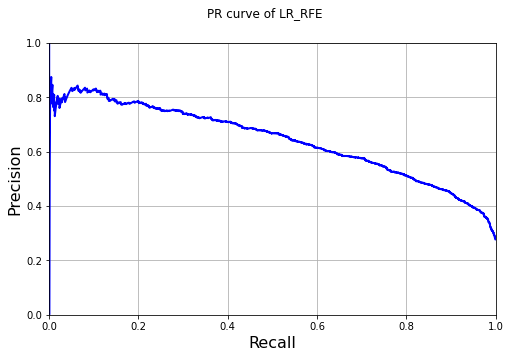

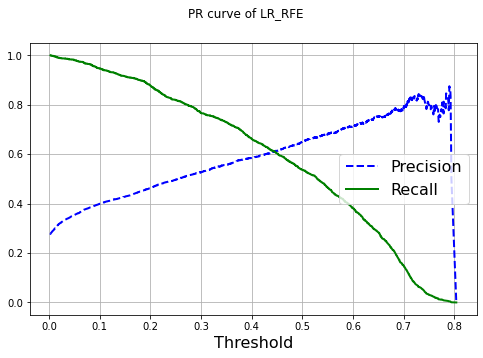

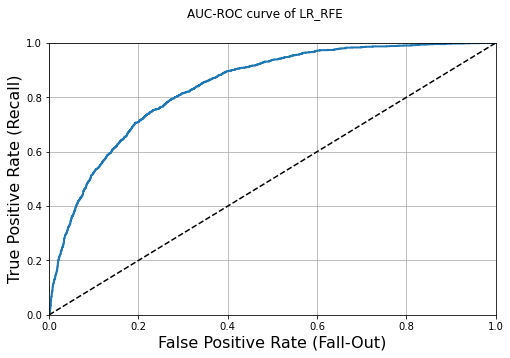

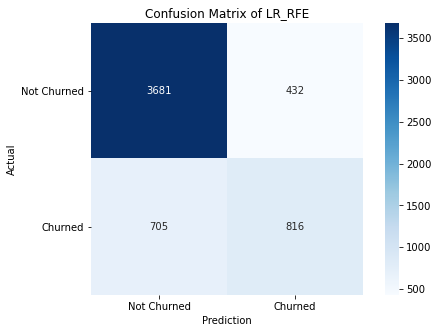

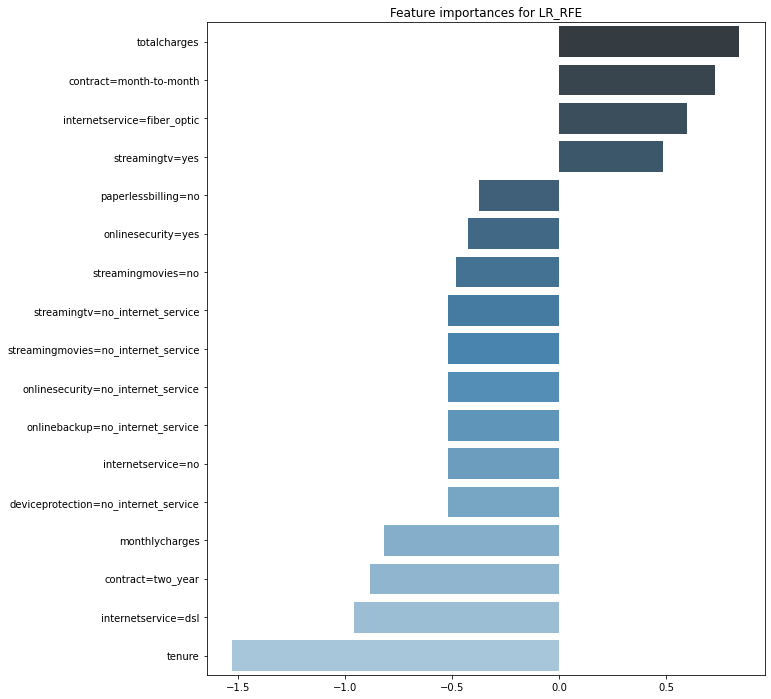

In [8]:
lr_rfe_model = LogisticRegression(solver='liblinear', random_state= 42)
lr_rfe_model_name = 'LR_RFE'
cv = 10
options = defaultdict(bool)
options['feature_importance_available'] =  True
options['coefficients'] = True

model_summary(lr_rfe_model_name, lr_rfe_model, X_train_full_scaled_rfe, y_train_full, X_train_scaled_rfe, 
                  y_train, X_val_scaled_rfe, y_val, cv, all_features_rfe, evaluation_metrics, 
              feature_selection_metrics_collector_map, options = options)

In [9]:
X_train_full_not_scaled_rfe = X_train_full_not_scaled[:, rfe.support_]
X_train_not_scaled_rfe = X_train_not_scaled[:, rfe.support_]
X_val_not_scaled_rfe = X_val_not_scaled[:, rfe.support_]

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      4113
           1       0.67      0.46      0.54      1521

    accuracy                           0.79      5634
   macro avg       0.74      0.69      0.70      5634
weighted avg       0.78      0.79      0.78      5634



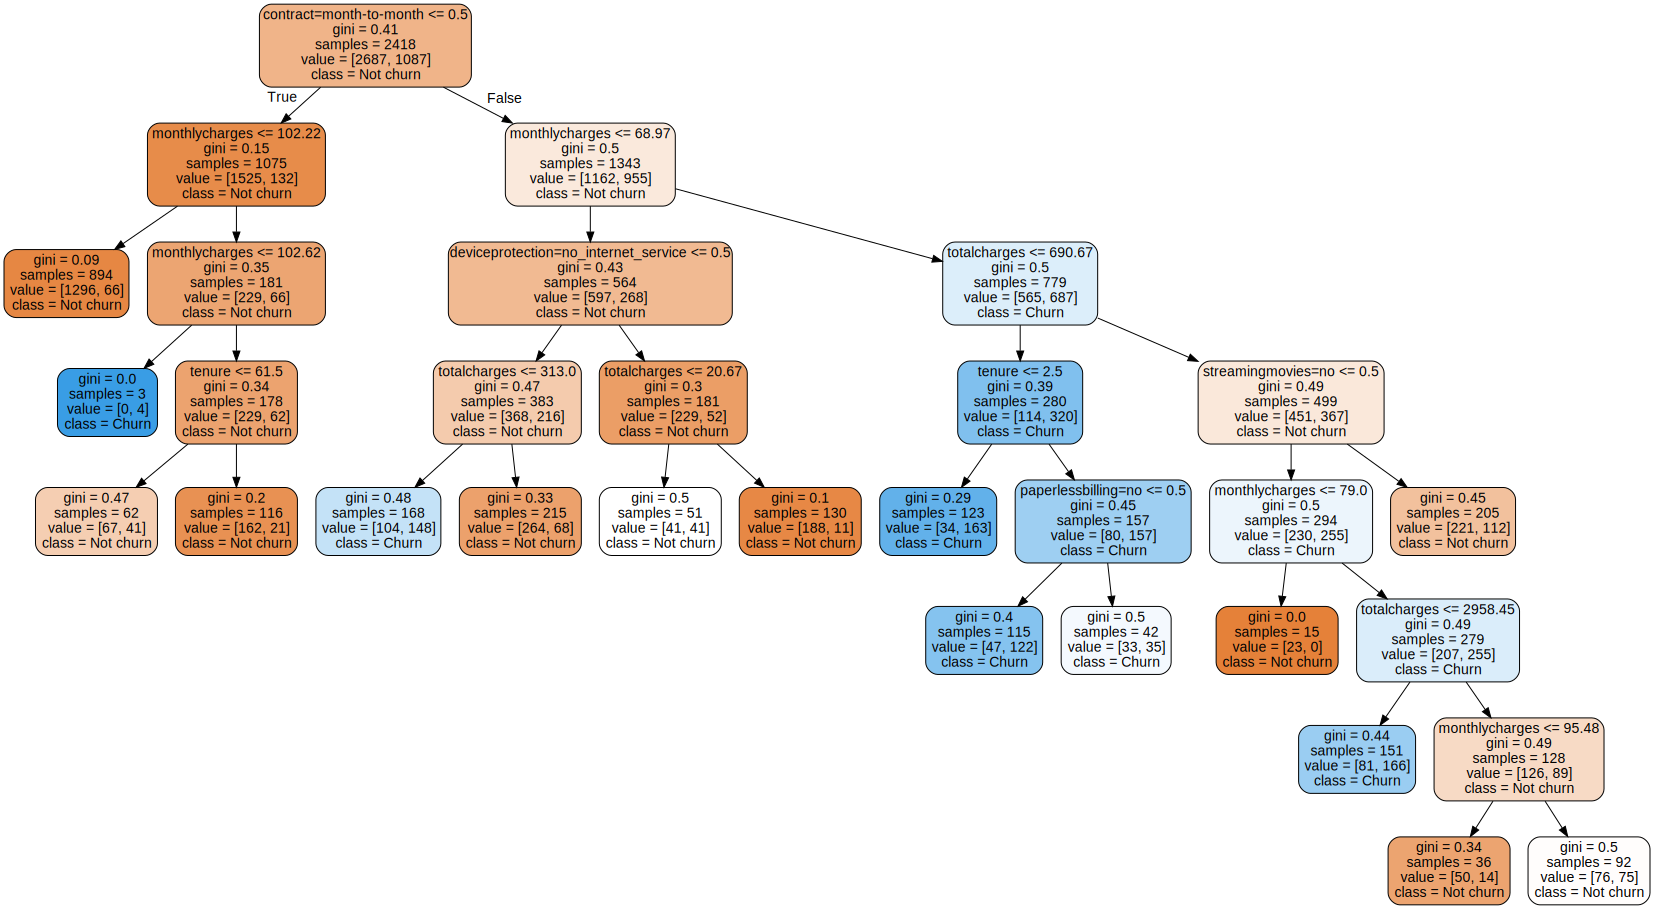

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR_RFE,0.567494,0.589023,0.840159,0.536468,0.654824,0.798192
1,RF_RFE,0.506726,0.542493,0.842143,0.458927,0.668118,0.792333


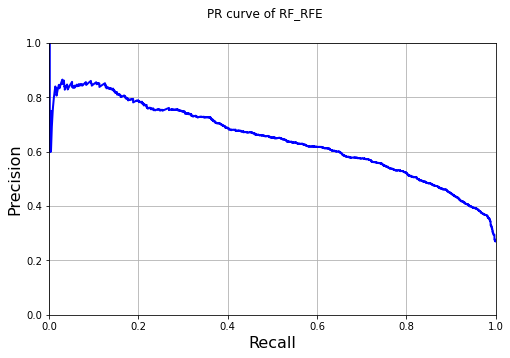

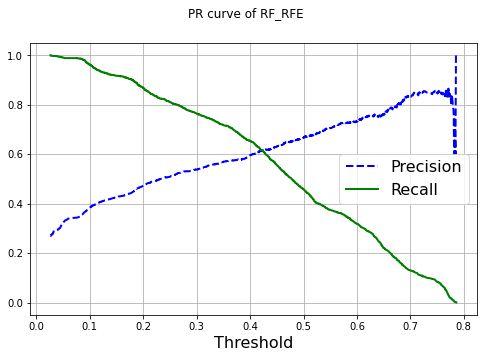

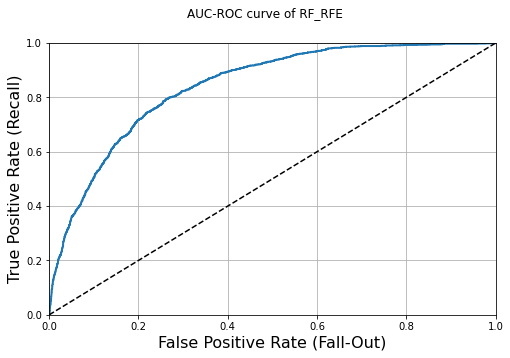

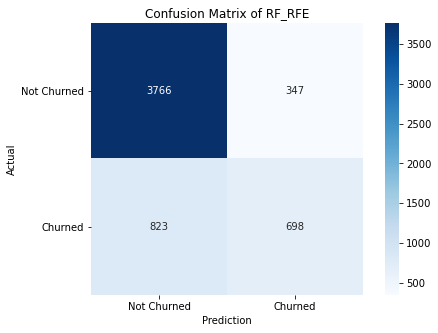

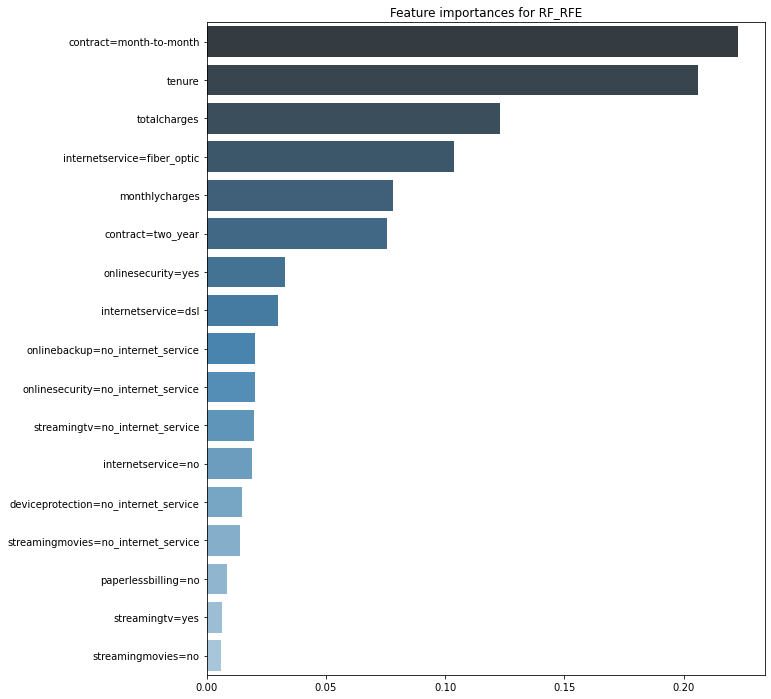

In [10]:
# Random Forest
random_forest_rfe_model = RandomForestClassifier(n_estimators=200, max_leaf_nodes=16, n_jobs=-1, random_state=7)
random_forest_rfe_model_name = 'RF_RFE'
cv = 10

options = defaultdict(bool)
options['feature_importance_available'] =  True
options['tree_based'] = True
options['estimated_tree'] = 190

model_summary(random_forest_rfe_model_name, random_forest_rfe_model, X_train_full_not_scaled_rfe, y_train_full, 
              X_train_not_scaled_rfe, y_train, X_val_not_scaled_rfe, y_val, cv, all_features_rfe, 
              evaluation_metrics, 
              feature_selection_metrics_collector_map,
              options = options)

### Univariate Selection

In [11]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

select = SelectKBest(score_func = chi2, k = 3)
fit = select.fit(X_train_full_not_scaled , y_train_full)

chi_score_df = pd.DataFrame(
    {"features" : feature_names,
     "scores" : fit.scores_,
     "p_values": fit.pvalues_ 
    })

chi_score_df = chi_score_df.sort_values(by = "scores" , ascending = False)
chi_score_df["feature_type"] = np.where(chi_score_df["features"].isin(numerical_features), "Numerical", "Categorical")

In [12]:
#top 3 categorical features
features_cat  = chi_score_df[chi_score_df["feature_type"] == "Categorical"]["features"][:3].tolist()

#top 3 numerical features
features_num  = chi_score_df[chi_score_df["feature_type"] == "Numerical"]["features"][:3].tolist()

In [13]:
X_train_full_not_scaled_top_cat = get_input_data_matrix_with_specific_features(X_train_full_not_scaled,
                                                               features_cat,
                                                               feature_names)

X_train_not_scaled_top_cat = get_input_data_matrix_with_specific_features(X_train_not_scaled,
                                                               features_cat,
                                                               feature_names)

X_val_not_scaled_top_cat = get_input_data_matrix_with_specific_features(X_val_not_scaled,
                                                               features_cat,
                                                               feature_names)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      4113
           1       0.54      0.53      0.54      1521

    accuracy                           0.75      5634
   macro avg       0.69      0.68      0.68      5634
weighted avg       0.75      0.75      0.75      5634



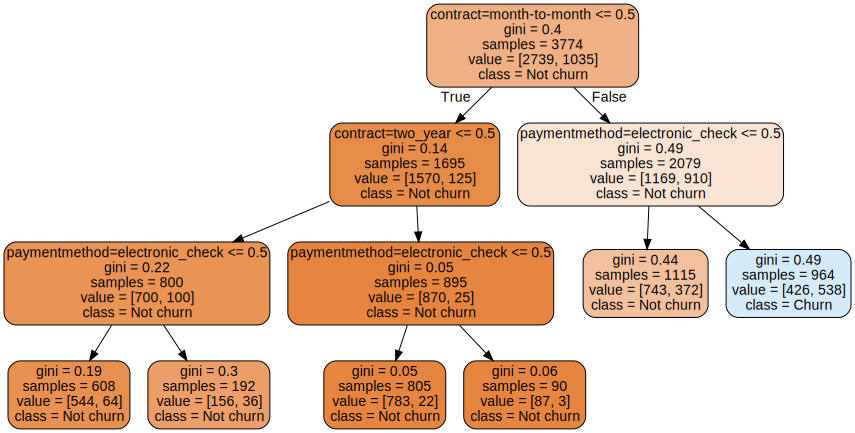

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR_RFE,0.567494,0.589023,0.840159,0.536468,0.654824,0.798192
1,RF_RFE,0.506726,0.542493,0.842143,0.458927,0.668118,0.792333
2,DT_top_cat,0.531336,0.534569,0.780841,0.526677,0.544168,0.752932


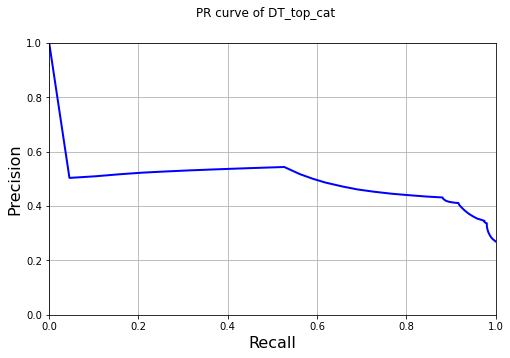

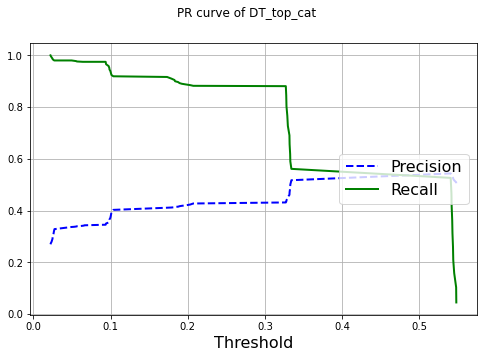

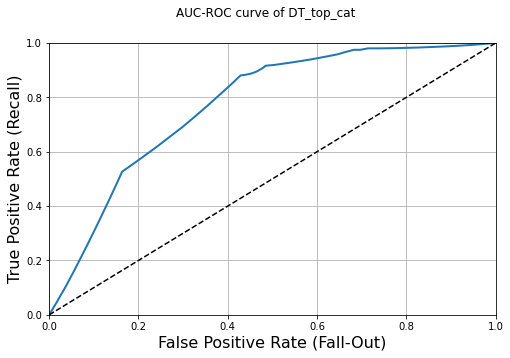

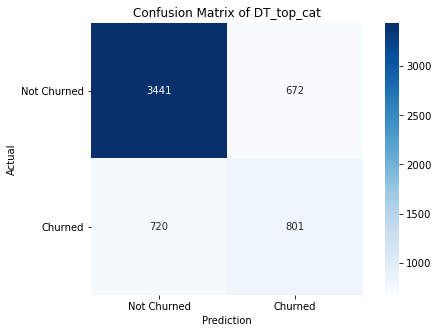

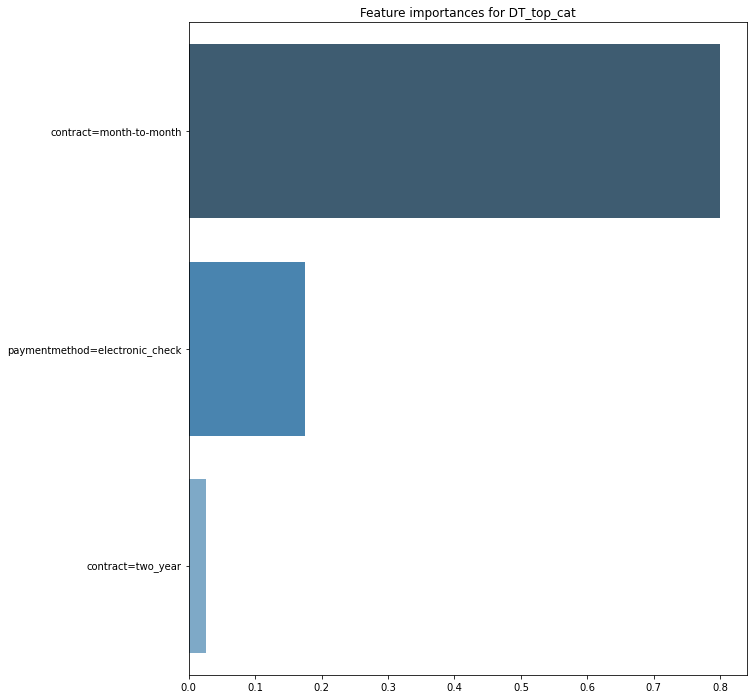

In [14]:
dt_classifier = DecisionTreeClassifier(random_state= 7, max_depth = 3)
dt_classifier_name = 'DT_top_cat'
cv = 10
options = defaultdict(bool)
options['feature_importance_available'] =  True
options['tree_based'] = True

model_summary(dt_classifier_name, dt_classifier, X_train_full_not_scaled_top_cat, y_train_full, 
              X_train_not_scaled_top_cat, y_train, X_val_not_scaled_top_cat, y_val, cv, features_cat, 
              evaluation_metrics, feature_selection_metrics_collector_map,
              options = options)

In [15]:
X_train_full_not_scaled_top_num = get_input_data_matrix_with_specific_features(X_train_full_not_scaled,
                                                               features_num,
                                                               feature_names)

X_train_not_scaled_top_num = get_input_data_matrix_with_specific_features(X_train_not_scaled,
                                                               features_num,
                                                               feature_names)

X_val_not_scaled_top_num = get_input_data_matrix_with_specific_features(X_val_not_scaled,
                                                               features_num,
                                                               feature_names)

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      4113
           1       0.64      0.40      0.50      1521

    accuracy                           0.78      5634
   macro avg       0.72      0.66      0.68      5634
weighted avg       0.76      0.78      0.76      5634



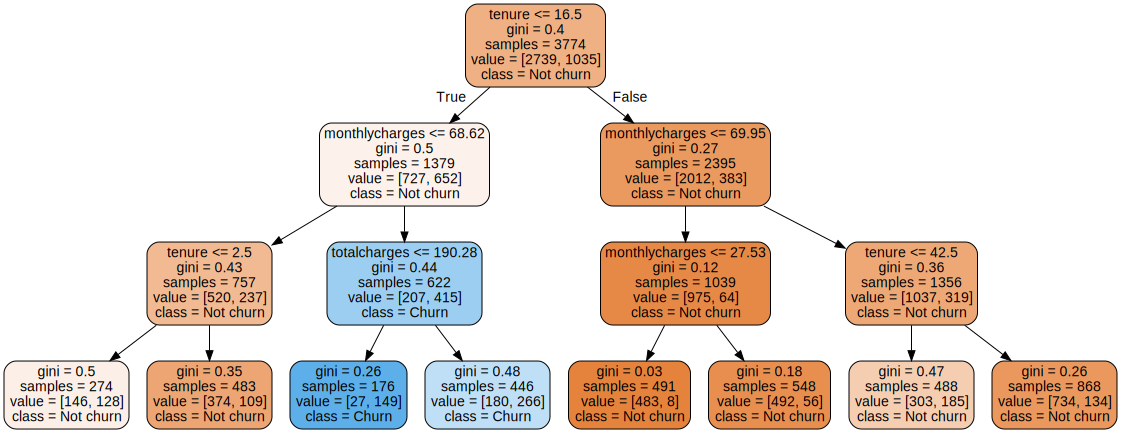

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR_RFE,0.567494,0.589023,0.840159,0.536468,0.654824,0.798192
1,RF_RFE,0.506726,0.542493,0.842143,0.458927,0.668118,0.792333
2,DT_top_cat,0.531336,0.534569,0.780841,0.526677,0.544168,0.752932
3,DT_top_num,0.455616,0.494407,0.784901,0.404992,0.636610,0.777245


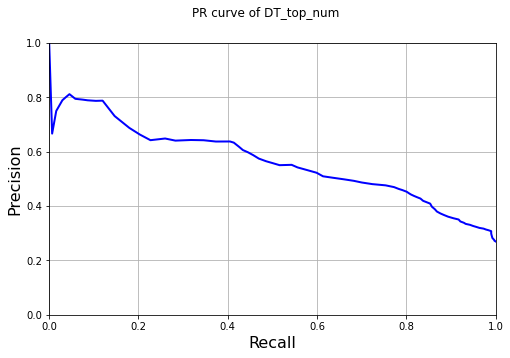

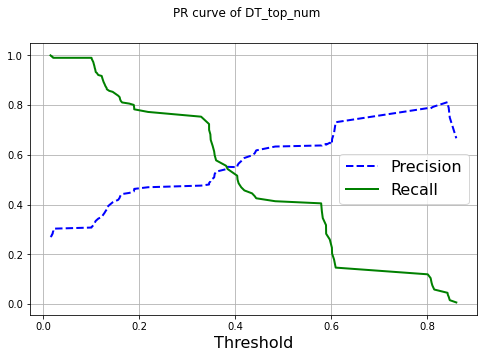

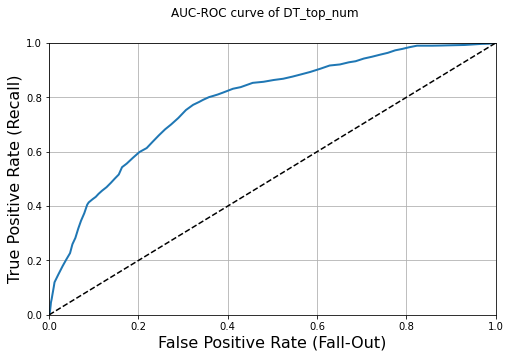

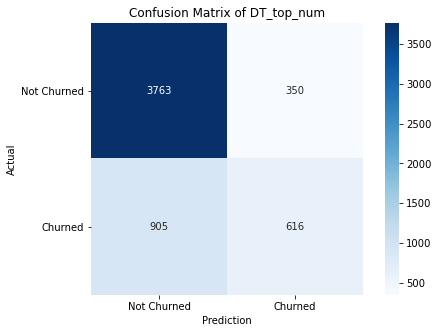

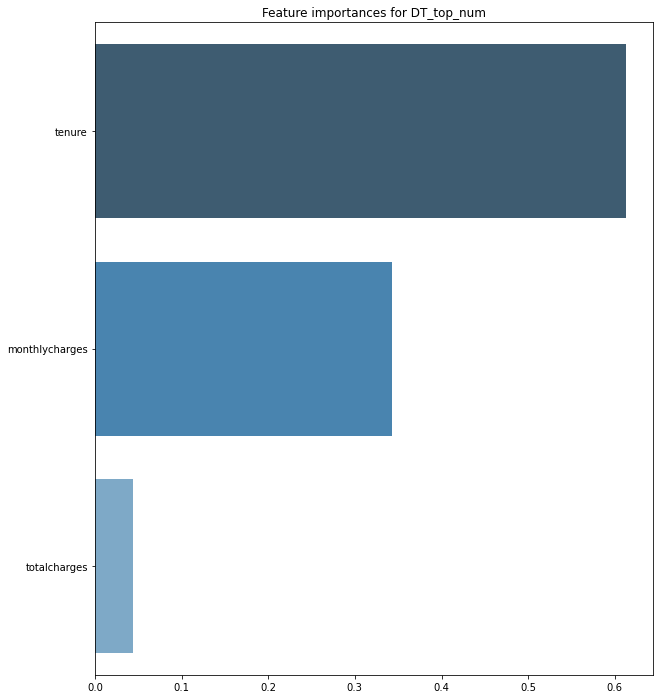

In [16]:
dt_classifier = DecisionTreeClassifier(random_state= 7, max_depth = 3)
dt_classifier_name = 'DT_top_num'
cv = 10
options = defaultdict(bool)
options['feature_importance_available'] =  True
options['tree_based'] = True

model_summary(dt_classifier_name, dt_classifier, X_train_full_not_scaled_top_num, y_train_full, 
              X_train_not_scaled_top_num, y_train, X_val_not_scaled_top_num, y_val, cv, features_num, 
              evaluation_metrics, feature_selection_metrics_collector_map,
              options = options)


## Comparing performance of models trained in Phase I, II and III

In [17]:
phase_one_model_to_evaluation_metrics_df_by_f1_point_5 = phase_one_model_to_evaluation_metrics_df.sort_values(by=['f1.5'],ascending=False)
phase_one_model_to_evaluation_metrics_df_by_f1_point_5

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120


In [18]:
model_to_mean_evaluation_metrics_with_smote_df_by_f1_point_5 = model_to_mean_evaluation_metrics_with_smote_df.sort_values(by=['f1.5'],ascending=False)
model_to_mean_evaluation_metrics_with_smote_df_by_f1_point_5

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.685354,0.630107,0.841196,0.797519,0.521142,0.747247
5,LDA,0.677498,0.622697,0.838220,0.788966,0.514777,0.741742
6,B_SVC,0.670541,0.604438,0.831488,0.812757,0.481121,0.722043
2,RF,0.666404,0.627118,0.837751,0.740987,0.544078,0.761982
1,DT,0.636844,0.591624,0.791567,0.725860,0.499632,0.729318
4,GNB,0.622011,0.568577,0.766290,0.732405,0.464943,0.699860
3,KNN,0.588759,0.548260,0.739152,0.667982,0.465316,0.702872


In [19]:
model_to_evaluation_metrics_with_feature_selection_df = pd.DataFrame(feature_selection_metrics_collector_map)
model_to_evaluation_metrics_with_feature_selection_df_f1_point_5 = model_to_evaluation_metrics_with_feature_selection_df.sort_values(by=['f1.5'],ascending=False)
model_to_evaluation_metrics_with_feature_selection_df_f1_point_5

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR_RFE,0.567494,0.589023,0.840159,0.536468,0.654824,0.798192
2,DT_top_cat,0.531336,0.534569,0.780841,0.526677,0.544168,0.752932
1,RF_RFE,0.506726,0.542493,0.842143,0.458927,0.668118,0.792333
3,DT_top_num,0.455616,0.494407,0.784901,0.404992,0.636610,0.777245


In [20]:
baseline_performance_metrics_df

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,Always Minority Class Baseline,0.534789,0.414322,0.5,1.0,0.26129,0.26129


Based on `fbeta score (beta = 1.5)` , we can select following models to further hyperparameter tuning:
- Logistic Regression with smote (Fbeta score = 0.685354)
- Random Forest with smote (Fbeta score = 0.666404)
- LDA with smote (Fbeta score = 0.677498)
- GNB with basic settings (Fbeta score  = 0.667782)

LDA in sklearn has no hyperparameters to tune. https://scikit-learn.org/stable/modules/lda_qda.html . Similarly GNB has no hyperparameters as well. We will now try to further fine tune our selected models:
- Logistic Regression with smote (Fbeta score = 0.685354)
- Random Forest with smote (Fbeta score = 0.666404)


In [21]:
%store model_to_evaluation_metrics_with_feature_selection_df

Stored 'model_to_evaluation_metrics_with_feature_selection_df' (DataFrame)
